In [166]:
#import library
import numpy as np
import math
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import trange,tqdm
import os
import csv
import threading
import csv
import pandas as pd
from matplotlib.colors import hsv_to_rgb

In [167]:
#import the dataset path
directory_path = [
    "dataset/grape_images/Black Rot",
    "dataset/grape_images/ESCA",
    "dataset/grape_images/Leaf Blight"
]

In [168]:
#reading image from multiple folder, converting it to RGB
data = []
file_name = []
label = []
for folder in directory_path:
  dataset = os.listdir(folder)
  for file in dataset:
    #creating full path to the curr file by joining the folder path
    #and file name using the content
    img_path = os.path.join(folder, file)
    #print(img_path)
    name = os.path.splitext(file)[0]
    #print(name)
    read_img = cv.imread(img_path)
    rgb_conv = cv.cvtColor (read_img, cv.COLOR_BGR2RGB)
    #append the RGB image data
    data.append(rgb_conv)
    #append the file name w/o extension
    file_name.append(name)
    label.append(folder)
    #print(file_name)

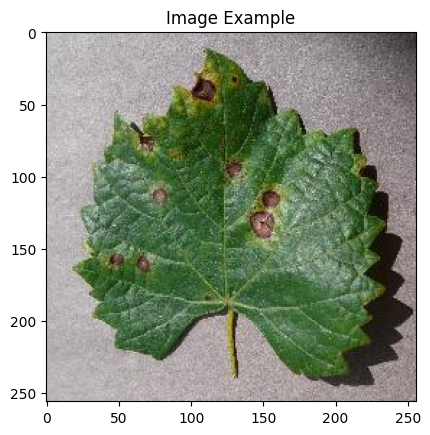

In [169]:
#displaying one of the image
data_ex = data[1]
plt.title("Image Example")
plt.imshow(data_ex, cmap = "gray")

In [170]:
#PreProcessing:Resizing Image
#use resizing for computational efficiency, making a standard to all of the image

resizing = []
for i in range (len(data)):
  #cv2.resize (source_image, desired_size,interpolation)
  #by using inter_nearest we replicate the values of the nearest pixel in the resized image
  temp = cv.resize(data[i],(256,256), interpolation=cv.INTER_NEAREST)
  resizing.append(temp)

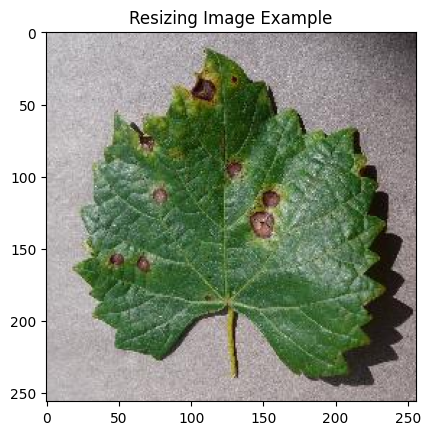

In [171]:
#displaying one of the image
data_ex = resizing[1]
plt.title("Resizing Image Example")
plt.imshow(data_ex, cmap = "gray")

In [172]:
#directory path for saving the resizing result
file_path = 'result/resizing/'

for i in range (len(resizing)):
  save = file_path + file_name[i] + ".jpg"
  rgb_conv = cv.cvtColor(resizing[i],cv.COLOR_BGR2RGB)
  cv.imwrite(save,rgb_conv)

In [173]:
# PreProcessing: Sharpening
kernel_sharpening = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])
sharpened = []
for i in range (len(resizing)):
    temp = cv.filter2D(resizing[i], -1, kernel_sharpening)
    sharpened.append(temp)

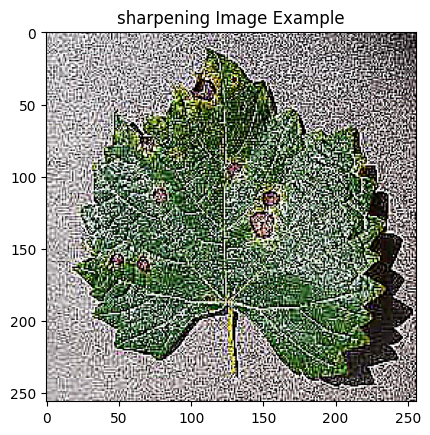

In [174]:
data_ex = sharpened[1]
plt.title("sharpening Image Example")
plt.imshow(data_ex, cmap = "gray")

In [175]:
file_path = 'result/sharpening/'

for i in range (len(sharpened)):
  save = file_path + file_name[i] + ".jpg"
  rgb_conv = cv.cvtColor(sharpened[i],cv.COLOR_BGR2RGB)
  cv.imwrite(save,rgb_conv)

In [176]:
# PreProcessing: segmentasi
lower_green = np.array([35, 50, 50])
upper_green = np.array([90, 255, 255])
segmentasi = []
for i in range (len(sharpened)):
    hsv = cv.cvtColor(sharpened[i], cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv, lower_green, upper_green)
    segmented_image = cv.bitwise_and(hsv, hsv, mask=mask)
    # _, threshold = cv.threshold(data[i], 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    segmentasi.append(segmented_image)

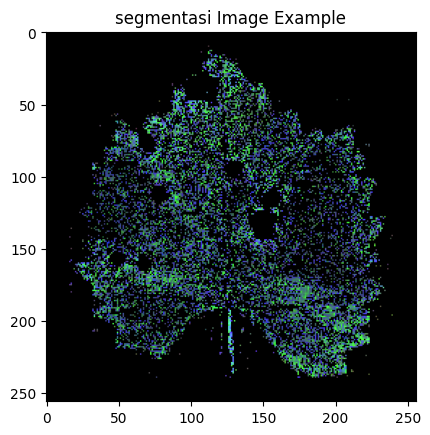

In [177]:
data_ex = segmentasi[1]
plt.title("segmentasi Image Example")
plt.imshow(data_ex)

In [178]:
file_path = 'result/Segmentasi/'

for i in range (len(segmentasi)):
  save = file_path + file_name[i] + ".jpg"
  rgb_conv = cv.cvtColor(segmentasi[i],cv.COLOR_BGR2RGB)
  cv.imwrite(save,rgb_conv)

# GLCM

In [179]:
def transpose(matrix):
    matrix_transpose = []
    row,col = matrix.shape
    for i in range(row):
        mRow = []
        for j in range(col):
            mRow.append(matrix[j][i])
        matrix_transpose.append(mRow)
    return matrix_transpose

In [180]:
def dataSum(image):
    result = 0
    for i in range (len(image)):
        for j in range(len(image)):
            result+=image[i,j]
    return result

In [181]:
def normalization(image):
    row, col = image.shape
    n = dataSum(image)
    for i in range(row):
        for j in range(col):
            image[i,j]/=n
    return image

In [182]:
def cooccurance (image, dimention, degree):
    row, col = image.shape
    matrixCo = np.zeros([dimention+1,dimention+1])
    if(degree == 0):
        for i in range(row):
            for j in range(col):
                if(j+1 < col):
                    matrixCo[image[i,j], image[i,j+1]] += 1
    elif (degree == 45):
        for i in range(row):
            for j in range(col):
                if(i-1 >= 0 and j+1 < col):
                    matrixCo[image[i,j], image[i-1,j+1]] += 1
    elif (degree == 90):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j]] += 1
    elif (degree == 135):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j+1]] += 1
    trans = transpose(matrixCo)
    sumMatrix = matrixCo+trans
    glcm = normalization(sumMatrix)
    return glcm

In [183]:
#ini fitur untuk GLCM nya (kontras, disimilaritas, homogenitas, entropi, ASM (Angular Second Moment), energi, dan korelasi)
#untuk setiap sudut (0, 45, 90, 135)
def mean(image):
    meanX=meanY= 0
    for i in range (len(image)):
        for j in range(len(image)):
            meanX += i * image[i,j]
            meanY += j * image[i,j]
    return meanX, meanY
def tao(image):
    taoX=taoY=0
    meanX,meanY= mean(image)
    for i in range (len(image)):
        for j in range(len(image)):
            taoX += pow((i-meanX),2)*image[i,j]
            taoY += pow((j-meanY),2)*image[i,j]
    return taoX, taoY
def extraction(image):
    energy=homogenity=entropy=contrast=disimilarity=correlation=ASM=0
    meanX, meanY = mean(image)
    taoX, taoY = tao(image)
    for i in range (len(image)):
        for j in range (len(image)):
            contrast += image[i,j]*pow((i-j),2)
            disimilarity += image[i,j]*abs(i-j)
            # homogenity += image[i,j]/1+(pow((i-j),2))
            homogenity += image[i,j]/1+abs(i-j)
            if image[i,j] > 0:
                entropy += -(image[i,j] * log(image[i,j]))
            ASM += pow(image[i,j],2)
            correlation+=((i-meanX)*(j-meanY)*image[i,j])/pow((taoX*taoY),1/2)
    energy = pow(ASM, 1/2)
    return contrast,disimilarity,homogenity,entropy,ASM,energy,correlation

In [184]:
def getGLCM(images):
    glcmImage = []
    for i in range(len(images)):
        glcm = []
        max = images[i].max()
        glcm.append(cooccurance(images[i],max,0))
        glcm.append(cooccurance(images[i],max,45))
        glcm.append(cooccurance(images[i],max,90))
        glcm.append(cooccurance(images[i],max,135))
        glcmImage.append(glcm)
    return glcmImage

In [185]:
csv = []
index = 0

for i in range (len(segmentasi)):
    extract = []
    extract.append(file_name[index])
    extract.append(label[index])
    index+=1
    glcm = getGLCM(segmentasi[i])
    contrast,disimilarity,homogenity,entropy,ASM,energy,correlation = extraction(glcm)
    extract.append(contrast)
    extract.append(disimilarity)
    extract.append(homogenity)
    extract.append(entropy)
    extract.append(ASM)
    extract.append(energy)
    extract.append(correlation)
    csv.append(extract)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
header = ['Name','Label','Contrast0','Dissimilarity0','Homogenity0','Entropy0','ASM0','Energy0','Correlation0'
           ,'Contrast45','Dissimilarity45','Homogenity45','Entropy45','ASM45','Energy45','Correlation45'
           ,'Contrast90','Dissimilarity90','Homogenity90','Entropy90','ASM90','Energy90','Correlation90'
           ,'Contrast135','Dissimilarity135','Homogenity135','Entropy135','ASM135','Energy135','Correlation135']
df = pd.DataFrame(csv, columns=header)

In [ ]:
df.to_csv(r'result/result.csv', index=False)

In [ ]:
df